<a href="https://colab.research.google.com/github/NataliaDiaz/XAI-tutorials/blob/main/SHAP_for_tabular_data_Credit_Risk_Scoring_v0_Ayoub_El_Qadi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP: *Understanding* the functioning of an ML-based credit risk scoring model

In this tutorial, you will learn how to apply eXplainable methods to machine learning models for tabular data. The goal is to understand how the models operate and what are the main criterias used for the decision making. Since we are working with tabular data, we will consider a  very familiar use-case.

Credit Scoring stands for the algorithms used to assess the credit worthiness of a person or more generally an entity (company, person ...).

 But what does this really means?. Let's take a quick example: Imagine you want to buy a car and you don't have enough money, so what do you do?. You go to the vendor and you demand a credit. Will the vendor give you the credit? It depends. It is at this point where credit scoring algorithms appears. They take as a input different kinds of data (financial, demographic, previous financial activities...) and output whether the vendor should or not give you the credit you asked for. In other words, they assess the probability of repaying your credit.

In this notebook, we will create a credit scoring algorithm and then apply XAI methods (SHAP, DICE ...) to help all the different stakeholders of these type of models understand the inner functioning.

The notebook is organized as follows:
1. We load the pre-processed data and analyze it.
2. We compare two different tree-based models used for the Credit Scoring : XGBoost (https://arxiv.org/abs/1603.02754) and Random Forest (https://doi.org/10.1023/A:1010933404324).
3. We apply SHAP Values (https://arxiv.org/abs/1705.07874).
4. We use DICE (Diverse Counterfactual Explanations) https://github.com/interpretml/DiCE.







## Loading and processing the original data

This files contains the original datasets used for the Loan Default Competition hosted by Zindi (https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction)

In [ ]:
#Set up for plotting results
import seaborn as sns
sns.set_style('dark')

In [ ]:
#Clone the github repository that contains all the data and the functions used to clean and prepare the data
! git clone https://github.com/ayoubelqadi/Loan-Default-Prediction.git

In [ ]:
#Loaded pandas, numpy and matplotlib.
#The code demands the user to chose between one hot encoding and delete categorical variables.
%run /content/Loan-Default-Prediction/code/data_processing.py

**Created variables in the work space: data_processing.py**

*DataFrames:*
1. train_perf: Is  the original datafrme in which the information about  loans performance. It contains the information about the loan demanded for client.
2. train_prevloan: It contains the customer historic loans.
3. train_demographics: It contains the demographic data of the customer.


4. demographics: it contains cleaned  demographic information.
5. prevloans: cleaned information about previous loans.
6. perf: cleaned data loan information.

7. final_data: contains the data that will be used for predicting the default. It is the result of merging the 4, 5, 6 tables using the customer as key.




**Data Processing Workflow**

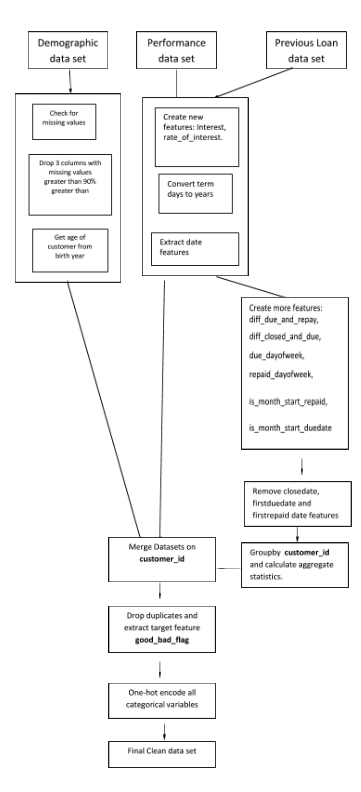

The diagram above shows the workflow used for processing the original data.  

### First look at the Data

The goal is to predict whether a customer will pay back the loan.(https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction). In this case the target variable is the variable **good_bad_flag**. In the original dataset, if the variable is equal to 1, it means that the customer has paid the loan. However for this use case we are going to set **good_bad_flag** to 1 if it is a bad loan (non repaid loan).
Let's check how many bad loans we have in the dataset

In [ ]:
X = final_data.copy()

In [ ]:
#Redefine target
X['good_bad_flag'] = X['good_bad_flag'].apply(lambda x: 1 if x==0 else 0)

In [ ]:
X['good_bad_flag'].value_counts()

In [ ]:
X['good_bad_flag'].value_counts(normalize=True).plot(kind='barh')
plt.title('Class distribution')

In [ ]:
#Check a random sample of the dataset
X.sample(n=1)

In [ ]:
#Categoric features
categoric_features = ['bank_name_clients', 'employment_status_clients', 'bank_account_type']
#Numeric features
numeric_features = x.columns.difference(categoric_features)


## SHAP Analysis
In this section, we are going to create the two different models (Random Forest and XGBoost). First we are going to encoding the categorical features which are bank_name_clients, employment_status_clients, and bank_account_type by using one hot encoding. Then we will check how good our model is. Later we are going to analyze the model functioning using Shap values

#### Data processing and modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

In [ ]:
#Features used to train the model
x = X.drop(columns=['good_bad_flag'])#.to_numpy()
#Target variable
y = X['good_bad_flag']#.to_numpy(dtype=np.int)
#One hot encoding categorical variables
x = pd.get_dummies(x)

In [ ]:
#We use the 70% of the data to train the model and the 30% to test the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=27)

**Let's create two tree based models and evaluate their performance**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
#Train the random forest
#Setting the weights for each class (not balanced dataset)
w0 = sum(y==0)/np.bincount(y).sum()
w1 = sum(y==1)/np.bincount(y).sum()
rf_params = rf_params = {
    'n_estimators': 1000,
    'max_depth': 20,
    'n_jobs': -1,
    'class_weight': {0:w0, 1:w1}
}
rf_model = RandomForestClassifier(**rf_params)
rf_model = rf_model.fit(x_train, y_train)

In [ ]:
#Train the xgboost model
#We create a dictionary that contains our model hyperparameters
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'subsample': 0.8,
    #'reg_alpha': 1,
    'max_depth': 10,
    'objective': 'binary:logistic',
    'scale_pos_weight': 5
}
xgb_model = XGBClassifier(**xgb_params)
xgb_model = xgb_model.fit(x_train, y_train)

In [ ]:
#Model assessment Random Forest
plot_confusion_matrix(rf_model, x_test, y_test, values_format='.3g')

In [ ]:
#Model Assessment XGBoost
plot_confusion_matrix(xgb_model, x_test, y_test, values_format='.3g')

#### Shap values

In [ ]:
# If SHAP is not installed
! pip install shap

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(xgb_model, x, model_output = "raw", feature_pertubation = "tree_path_dependent")
shap_values = explainer.shap_values(x)

**Local interpretability: How do we interpret the SHAP forceplot?**


The values we observe are the natural logarithm of the odd ratio $ln(\frac{P(Y=1)}{1-P(Y=1)})$. The SHAP values can be understood as forces that push the output of the model. Blue forces (shap values) repreents the features that increase the probability of default while red values represent the features that are incrementing the probability of paying the loan. 

Forceplot allow us to study a concrete case in order to give a reason for rejecting or approving a loan. If we were the vendor, for this particular client, we would approve the loan because



In [ ]:
shap.initjs()
client_index = 123
shap.force_plot(explainer.expected_value, shap_values[client_index,:], x.iloc[client_index,:])

In [ ]:
#Client real target value
y.iloc[client_index]

In [ ]:
#Client data
x.loc[client_index:client_index, :]

In [ ]:
#Probability of non repaying the credit given by the model
p1 = xgb_model.predict_proba(x.loc[client_index:client_index, :])[0][1]
print('Probability of default given by our model: {} %'.format(round(p1*100, 3)))

In [ ]:
#Computed log odd Shown in the force plot
np.log(p1/(1-p1))

**Global interpretability: Summary plot.**

The summary plot allow us to understand the model by ranking the features from the most relevant to the less important one. Each point represents a different person. In our concrete use case, the most relevant feature is the mean delay between payment of the first due and the payment date accorded with the institution. High values of this feature impact negatively in the output of the model (the probability of default increases). Now we have interpret these results, we can wonder if how the model works match with what we consider as criteria for credit scoring. In this case, it seems logic how it consider this feature. We can make a similar anlysis for the interest rate feature. 

The main features for our model are the delay of payment, the location (latitude and longitude), and the interest rate of the considered loan.



For some features, the points (individuals) are extremely close making the interpretation complicate. In order to go further we will need different plots.





In [ ]:
shap.summary_plot(shap_values, x)

## Diverse Counterfactual Explanations

**DiCE** 

#### Data processing and modeling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
x = X.drop(columns=['good_bad_flag'])#.to_numpy()
y = X['good_bad_flag']#.to_numpy(dtype=np.int)
#We use the 70% of the data to train the model and the 30% to test the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=27)

In [ ]:
#Define the categorical and numerical features
categoric_features = ['bank_name_clients', 'employment_status_clients', 'bank_account_type']
numeric_features = x.columns.difference(categoric_features)
#Define the encoder for categorical valeus
categorical_transformer = Pipeline(steps=[
                                          ('onehot', OneHotEncoder())
])
#Define the strategy to apply to numerical data
numeric_transformer = Pipeline(steps=[
                                      ('standard_scaler', StandardScaler())
])
#Transfoerme: it takes the orifgianl data and transform categorical and numerical features
preprocessor = ColumnTransformer(transformers=[
                                               ('numeric', numeric_transformer, numeric_features),
                                               ('categorical', categorical_transformer, categoric_features)
])


**Random Forest**


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Define the weights for each class
w0 = sum(y==0)/np.bincount(y).sum()
w1 = sum(y==1)/np.bincount(y).sum()
rf_params = {
    'n_estimators': 1000,
    'max_depth': 20,
    'n_jobs': -1,
    'class_weight': {0:w0, 1:w1}
}

In [ ]:
#Model object: it takes the original data, process it and apply the random forest
clf_rf = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(**rf_params))
])

In [ ]:
#Train the model
rf_model = clf.fit(x_train, y_train)

In [ ]:
#Model assessment
plot_confusion_matrix(rf_model, x_test, y_test, values_format='.3g')

**XGBoost model**


In [ ]:
#Loading the libraries that we need to build our model
import xgboost as xgb

In [ ]:
#We create a dictionary that contains our model hyperparameters
params_xgb = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'subsample': 0.8,
    #'reg_alpha': 1,
    'max_depth': 10,
    'objective': 'binary:logistic',
    'scale_pos_weight': 5
}
clf_xgb = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(**params_xgb))
])

clf_xgb = clf_xgb.fit(x_train, y_train)


In [ ]:
plot_confusion_matrix(xgb_model, x_test, y_test, values_format='.3g')

#### DICE 

In [ ]:
#If DICE is not installed
! pip install dice-ml

In [ ]:
#Loading the dice module
import dice_ml
from dice_ml.utils import helpers  

In [ ]:
#DiCE data object
data = dice_ml.Data(dataframe=final_data, continuous_features=list(numeric_features), outcome_name='good_bad_flag')
#DiCE model object
model_exp = dice_ml.Model(model=xgb_model, backend='sklearn')
#Creates the explanations 
exp = dice_ml.Dice(data, model_exp, method="random")

In [ ]:
#We take an example of our training set 
#We set the number of counterfactual explanations to 2. 
e1 = exp.generate_counterfactuals(x_train[354:355], total_CFs=2, desired_class="opposite")
#Show counterfactual explanations
e1.visualize_as_dataframe(show_only_changes=True)